In [1]:
from torch_rnn import train, RNN, process_data, randomTrainingExample, categoryFromOutput
import torch
import torch.nn as nn
import string
import time
import math

[]


In [2]:
file_path = 'data/data/names/*.txt'

In [3]:
category_lines, all_categories, n_categories = process_data(file_path)

In [4]:
print(n_categories)

18


In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [6]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 5e-4

In [7]:
n_iters = 200000
print_every = 5000
plot_every = 1000

In [8]:
# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

In [9]:
for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample(category_lines, all_categories)
    output, loss = train(rnn, criterion, category_tensor, line_tensor, learning_rate)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output, all_categories)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 2% (0m 15s) 2.1675 Bouloukos / Greek ✓
10000 5% (0m 29s) 2.8926 Jenicek / Greek ✗ (Czech)
15000 7% (0m 43s) 3.2808 Moy / Japanese ✗ (Chinese)
20000 10% (0m 58s) 2.7668 Kunze / Dutch ✗ (German)
25000 12% (1m 15s) 2.8041 Ha / Japanese ✗ (Korean)
30000 15% (1m 28s) 2.5564 Tillens / French ✗ (German)
35000 17% (1m 41s) 4.5238 Seok / Polish ✗ (Korean)
40000 20% (1m 54s) 1.5097 Ruadh / Irish ✓
45000 22% (2m 8s) 1.5370 Grigorchikov / Greek ✗ (Russian)
50000 25% (2m 21s) 2.9539 Karl / Czech ✗ (Dutch)
55000 27% (2m 37s) 1.2827 Zhunusov / Russian ✓
60000 30% (2m 51s) 1.6367 Lombardi / Italian ✓
65000 32% (3m 4s) 1.0205 Atabekov / Greek ✗ (Russian)
70000 35% (3m 19s) 2.6842 Kerner / German ✗ (Czech)
75000 37% (3m 33s) 6.3652 Park  / Polish ✗ (Korean)
80000 40% (3m 47s) 1.6210 Masih / Japanese ✗ (Arabic)
85000 42% (4m 2s) 0.6378 Fenstermacher / German ✓
90000 45% (4m 17s) 1.3146 Leroy / French ✓
95000 47% (4m 30s) 2.9645 Santos / Greek ✗ (Portuguese)
100000 50% (4m 42s) 2.7681 Fraser / Portug

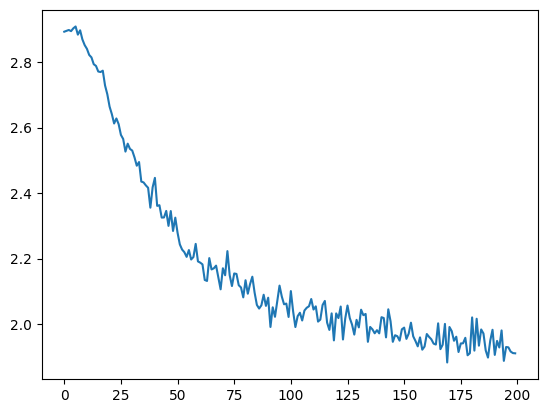

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# todo: experiment with intializations and learning rate